<a href="https://colab.research.google.com/github/rHarris4080/Capstone2/blob/main/Capstone2_Supervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Capstone 2 - Supervised Learning: Predicting Used Car Listing Prices
#Robert L Harris 
##4/14/21

The dataset of interest was found on Kaggle.com.  It is composed of vehicles for sale on Craigslist.com compiled by Austin Reese.  The dataset has approximately 500k listings throughout the USA.  My computer was unable to download the entire csv file(267MB) do to hardware limitations.  Therefore, the file was split into 46 separate files having 10K listings apiece.  A looping algorithm was used to load in multiple files for investigation purposes.  The dataset was then filtered to only look at California listings.  Those listings were stored on 5 of the 46 files (vehicles_2.csv - vehicles_6.csv).  While California was the state of interest, the code could be easily adjusted to accommodate any state of interest.  One could even adjust it per generalized region (NW, W, SW, etc...).

##Task:
Write a Supervised Learning model to predict the appropriate asking price of an automobile for sale on Craigslist.com.  Our investigation will use California as the testing ground, but the model could be easily adjusted to look at any other state or region as stated earlier.

##Linear Regression: 
A linear regression approach will be pursued as the target listing price, a continuous variable, should increase on average over time.  Multiple models will be implemented once the dataset is cleaned and feature engineering is completed on all the categories of interest. 

##Stakeholders:
Anyone interested in listing their vehicle on Craigslist.com should have an idea of an appropriate listing price depending on particular parameters (i.e. make, model, miles, year, etc...).  If the best model gives an adequate result, then the individual would have a good idea of what to ask as a listing price for their vehicle.

##Limitations:
Unfortunately, the sale price is not of record.  Knowing the sale price would allow much more flexibility in the direction to pursue my analysis.  Predicting sale price is much more informative in my opinion that predicting the listing price.  Likewise, knowing the sales price along with listing price would allow for some basic inference regarding "if listing price with these features, then expect a possible sale price in this range as determined by some margin of error".  One would also be able to pursue the concept of maximizing sale price depending on differing factors.

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

#Set up access the dataset
from google.colab import files 
import io

In [ ]:
#vehicles_0 is loaded for column names.
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['vehicles_0.csv']))


Saving vehicles_0.csv to vehicles_0.csv


In [ ]:
def get_data(file_csv):
  uploaded = files.upload() 
  df = pd.read_csv(io.BytesIO(uploaded[file_csv]))  
  return df

In [ ]:
file_list = ['vehicles_2.csv', 'vehicles_3.csv', 'vehicles_4.csv',
             'vehicles_5.csv', 'vehicles_6.csv']

for file_csv in file_list:
  df_csv = get_data(file_csv)
  df_csv.columns = df.columns

  file = [df, df_csv]
  df = pd.concat(file, ignore_index=True)

Saving vehicles_2.csv to vehicles_2.csv


Saving vehicles_3.csv to vehicles_3.csv


Saving vehicles_4.csv to vehicles_4.csv


Saving vehicles_5.csv to vehicles_5.csv


Saving vehicles_6.csv to vehicles_6.csv


##Some preliminary investigation:

In [ ]:
df.shape

(60000, 26)

In [ ]:
df.head()

,Unnamed: 0,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,0,7240372487,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,35990,2010.0,chevrolet,corvette grand sport,good,8 cylinders,gas,32742.0,clean,other,1G1YU3DW1A5106980,rwd,NaN,other,NaN,https://images.craigslist.org/00N0N_ipkbHVZYf4...,Carvana is the safer way to buy a car During t...,al,32.590000,-85.480000,2020-12-02T08:11:30-0600
1,1,7240309422,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,7500,2014.0,hyundai,sonata,excellent,4 cylinders,gas,93600.0,clean,automatic,5NPEC4AB0EH813529,fwd,NaN,sedan,NaN,https://images.craigslist.org/00s0s_gBHYmJ5o7y...,I'll move to another city and try to sell my c...,al,32.547500,-85.468200,2020-12-02T02:11:50-0600
2,2,7240224296,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,4900,2006.0,bmw,x3 3.0i,good,6 cylinders,gas,87046.0,clean,automatic,NaN,NaN,NaN,SUV,blue,https://images.craigslist.org/00B0B_5zgEGWPOrt...,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al,32.616807,-85.464149,2020-12-01T19:50:41-0600
3,3,7240103965,https://auburn.craigslist.org/cto/d/lanett-tru...,auburn,https://auburn.craigslist.org,2000,1974.0,chevrolet,c-10,good,4 cylinders,gas,190000.0,clean,automatic,NaN,rwd,full-size,pickup,blue,https://images.craigslist.org/00M0M_6o7KcDpArw...,1974 chev. truck (LONG BED) NEW starter front ...,al,32.861600,-85.216100,2020-12-01T15:54:45-0600
4,4,7239983776,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,19500,2005.0,ford,f350 lariat,excellent,8 cylinders,diesel,116000.0,lien,automatic,NaN,4wd,full-size,pickup,blue,https://images.craigslist.org/00p0p_b95l1EgUfl...,2005 Ford F350 Lariat (Bullet Proofed). This t...,al,32.547500,-85.468200,2020-12-01T12:53:56-0600


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    60000 non-null  int64  
 1   id            60000 non-null  int64  
 2   url           60000 non-null  object 
 3   region        60000 non-null  object 
 4   region_url    60000 non-null  object 
 5   price         60000 non-null  int64  
 6   year          59867 non-null  float64
 7   manufacturer  57886 non-null  object 
 8   model         59322 non-null  object 
 9   condition     36805 non-null  object 
 10  cylinders     37209 non-null  object 
 11  fuel          59767 non-null  object 
 12  odometer      52222 non-null  float64
 13  title_status  59546 non-null  object 
 14  transmission  59743 non-null  object 
 15  VIN           37299 non-null  object 
 16  drive         41869 non-null  object 
 17  size          16886 non-null  object 
 18  type          46557 non-nu

In [ ]:
df.state.unique()

array(['al', 'ak', 'az', 'ar', 'ca', 'co'], dtype=object)

##Filter and investigate California:

In [ ]:
# Filter CA listing only & reset index at 0

cars = df.copy()[df['state']=='ca']        #FYI: cars = df[df['state']=='ca']
cars.reset_index(drop=True, inplace=True)

cars.head(3)

,Unnamed: 0,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,22141,7240678054,https://bakersfield.craigslist.org/ctd/d/fonta...,bakersfield,https://bakersfield.craigslist.org,74995,2019.0,ford,f-250sd,NaN,NaN,diesel,13388.0,clean,automatic,1FT7W2BT5KEE29401,4wd,NaN,NaN,NaN,https://images.craigslist.org/00Y0Y_axZeBhuY2f...,2019 Ford F-250SD Lariat 4WD 4D Crew Cab 8 cy...,ca,34.070311,-117.446303,2020-12-02T14:01:31-0800
1,22142,7240677725,https://bakersfield.craigslist.org/ctd/d/orang...,bakersfield,https://bakersfield.craigslist.org,9997,2014.0,honda,civic bad credit,like new,NaN,gas,77000.0,clean,automatic,NaN,NaN,NaN,SUV,black,https://images.craigslist.org/01616_c5SrAatbtj...,We offer HIGHLY AGGRESSIVE financing for those...,ca,33.788216,-117.833248,2020-12-02T14:00:56-0800
2,22143,7240673013,https://bakersfield.craigslist.org/ctd/d/orang...,bakersfield,https://bakersfield.craigslist.org,23997,2015.0,nissan,armada bad credit,excellent,8 cylinders,gas,55000.0,clean,automatic,NaN,NaN,NaN,SUV,black,https://images.craigslist.org/00n0n_a18VfwAZOT...,"😍 We are very pleased to offer for sale this ""...",ca,33.811000,-117.849300,2020-12-02T13:53:15-0800


###Only 16 of the original 26 categories are of interest.  We will eliminate the categories having little to no effect on the target price.  Those columns are:
1. Unamed:0
2. id
3. url
4. region_url
5. VIN
6. image_url
7. descriprion
8. lat
9. long
10. posting_date


In [ ]:
cars.drop(columns = ['Unnamed: 0', 'id', 'url','region_url','VIN','image_url', 'description','lat', 'long', 'posting_date'], inplace=True )
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45634 entries, 0 to 45633
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        45634 non-null  object 
 1   price         45634 non-null  int64  
 2   year          45573 non-null  float64
 3   manufacturer  44028 non-null  object 
 4   model         45076 non-null  object 
 5   condition     29714 non-null  object 
 6   cylinders     27506 non-null  object 
 7   fuel          45488 non-null  object 
 8   odometer      40144 non-null  float64
 9   title_status  45344 non-null  object 
 10  transmission  45451 non-null  object 
 11  drive         31547 non-null  object 
 12  size          12860 non-null  object 
 13  type          36028 non-null  object 
 14  paint_color   31669 non-null  object 
 15  state         45634 non-null  object 
dtypes: float64(2), int64(1), object(13)
memory usage: 5.6+ MB


### Remove entries without a year because year is a key feature.

In [ ]:
years_null = cars.year.isnull().value_counts()
years_null

False    45573
True        61
Name: year, dtype: int64

In [ ]:
cars = cars[cars['year'].notna()] 

print(len(cars[cars['year'].isnull()==True]))
print(len(cars))

0
45573


In [ ]:
# typecast floats to int
cars['price'] = cars['price'].astype(int)
cars['year'] = cars['year'].astype(int)

##Continue to explore and clean continuous variables:

In [ ]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45573 entries, 0 to 45633
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        45573 non-null  object 
 1   price         45573 non-null  int64  
 2   year          45573 non-null  int64  
 3   manufacturer  44028 non-null  object 
 4   model         45015 non-null  object 
 5   condition     29714 non-null  object 
 6   cylinders     27445 non-null  object 
 7   fuel          45436 non-null  object 
 8   odometer      40083 non-null  float64
 9   title_status  45291 non-null  object 
 10  transmission  45390 non-null  object 
 11  drive         31489 non-null  object 
 12  size          12860 non-null  object 
 13  type          35967 non-null  object 
 14  paint_color   31620 non-null  object 
 15  state         45573 non-null  object 
dtypes: float64(1), int64(2), object(13)
memory usage: 5.9+ MB


In [ ]:
cars.describe()

,price,year,odometer
count,45573.000,45573.000,40083.000
mean,77950.571,2010.682,87807.928
std,13155228.895,9.653,162307.725
min,0.000,1900.000,0.000
25%,5950.000,2008.000,36103.000
50%,12500.000,2013.000,75000.000
75%,22985.000,2016.000,120000.000
max,2808348671.000,2021.000,10000000.000


###Investigate a minimum odometer and price reading of 0.  Also, max price of $2,808,349,000 and a max odometer of 10,000,000?  From the Rich and Famous to the poster child for using Firestone to prolong the life of your car!!!

In [ ]:
print(len(cars[cars['odometer']==0]))
print(len(cars[cars['price']==0]))

352
3725


###Eliminate all records where price = 0

In [ ]:
cars.drop(cars[cars.price == 0].index, inplace=True)
len(cars[cars.price == 0])

0

In [ ]:
# Investigate odometer issues:

cars[cars['odometer']==0].head(5)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
171,bakersfield,39990,2014,NaN,John Deere Loader,excellent,NaN,gas,0.0,clean,automatic,NaN,NaN,NaN,orange,ca
174,bakersfield,12990,2020,NaN,CTEC 128-38-VFT-95,excellent,NaN,gas,0.0,clean,automatic,NaN,NaN,NaN,white,ca
1387,bakersfield,6498,2008,honda,cr-v,excellent,4 cylinders,gas,0.0,clean,automatic,fwd,NaN,SUV,blue,ca
2653,chico,4995,2002,chevrolet,trailblazer,good,6 cylinders,gas,0.0,clean,automatic,4wd,mid-size,SUV,red,ca
2992,chico,8999,2010,nissan,murano,excellent,6 cylinders,gas,0.0,clean,automatic,4wd,NaN,SUV,NaN,ca


In [ ]:
cars[cars['odometer'].isnull()==True].head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
212,bakersfield,7975,2014,chevrolet,traverse,excellent,6 cylinders,gas,nan,clean,automatic,fwd,full-size,SUV,black,ca
213,bakersfield,6975,2014,buick,verano,excellent,4 cylinders,gas,nan,clean,automatic,fwd,mid-size,sedan,black,ca
216,bakersfield,9997,2014,honda,civic bad credit,like new,NaN,gas,nan,clean,automatic,NaN,NaN,SUV,black,ca
217,bakersfield,7975,2012,ford,mustang,excellent,6 cylinders,gas,nan,clean,automatic,fwd,mid-size,convertible,black,ca
218,bakersfield,6800,2012,honda,civic,NaN,NaN,gas,nan,clean,automatic,NaN,NaN,sedan,NaN,ca


## We are not willing to give up on a 0 or Nan odometer readings just yet.  This might have just been forgotten in the listing for some reason.  So we will initially sort the data by year and fill with a rolling average of the surrounding 50 odometer readings.

In [ ]:
# Replace all odometer readings of 0 to NaN for the following cell that converts Nan vqlues to the rolling average of 25 surrounding values.
cars['odometer'].loc[(cars['odometer'] == 0.0)] = np.nan

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
cars_t = cars.copy()
cars_t.sort_values(by=['year'], inplace=True)

cars_t['odometer'].fillna(cars_t['odometer'].rolling(50, min_periods=1).mean(), inplace=True)
cars_t.sort_values(by=['region'], inplace=True, ascending=False)

cars = cars_t
print(len(cars[cars['odometer'].isnull()==True]))
print(len(cars[cars['odometer']==0]))

0
0


In [ ]:
cars.reset_index(drop=True, inplace=True)
cars['odometer'] = cars['odometer'].astype(int)

print(cars.shape)
cars.head()

(41848, 16)


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,yuba-sutter,25999,2007,chevrolet,corvette,excellent,8 cylinders,gas,53846,clean,manual,rwd,NaN,coupe,black,ca
1,yuba-sutter,4999,1999,honda,accord ex,excellent,6 cylinders,gas,203881,clean,automatic,NaN,NaN,sedan,NaN,ca
2,yuba-sutter,10999,2012,nissan,maxima,excellent,6 cylinders,gas,98898,clean,automatic,fwd,mid-size,sedan,silver,ca
3,yuba-sutter,38500,2012,ford,f-150,excellent,8 cylinders,gas,107020,clean,automatic,4wd,full-size,pickup,black,ca
4,yuba-sutter,15999,2009,lexus,is 250,excellent,6 cylinders,gas,45704,clean,automatic,rwd,sub-compact,sedan,red,ca


###Checking continuous variable outliers:

In [ ]:
cars.price.sort_values()

23129             1
16066             1
34325             1
30349             1
31755             1
            ...    
12914        339998
23885        599000
9391         888777
37018      11111111
25164    2808348671
Name: price, Length: 41848, dtype: int64

In [ ]:
cars.odometer.sort_values()

11861           1
18669           1
41246           1
4638            1
40192           1
           ...   
32724    10000000
31645    10000000
40958    10000000
30952    10000000
10283    10000000
Name: odometer, Length: 41848, dtype: int64

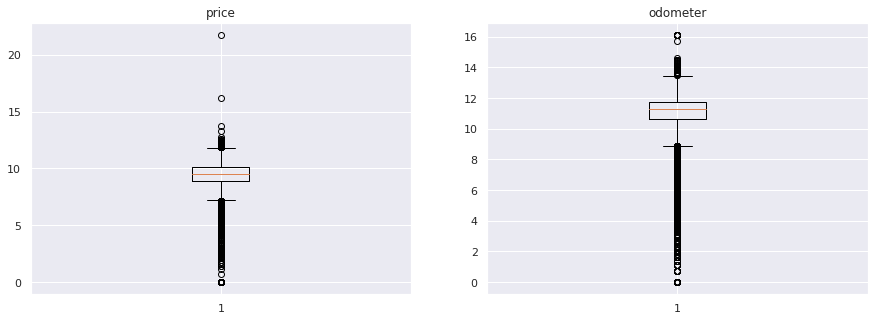

In [ ]:
# Box Plot visualizing investigating outliers
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(np.log(cars["price"]), whis=1.5)
plt.title("price")

plt.subplot(1,2,2)
plt.boxplot(np.log(cars["odometer"]), whis=1.5)
plt.title("odometer")
plt.show()

In [ ]:
# Determine number of outliers:

def tukey_IQR(cars, col):
  q75, q25 = np.percentile(cars[col], [75 ,25])
  iqr = q75 - q25

  for threshold in np.arange(1,2,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("\tThe score threshold is: {}".format(threshold))
    print("\tNumber of outliers is: {}".format(
        len((np.where((cars[col] > max_val) 
                      | (cars[col] < min_val))[0]))
    ))


In [ ]:
print("Tukey IQR Outliers -  price:")
tukey_IQR(cars, "price")

print("\nTukey IQR Outliers -  odometer:")
tukey_IQR(cars, "odometer")

Tukey IQR Outliers -  price:
	The score threshold is: 1.0
	Number of outliers is: 2551
	The score threshold is: 1.5
	Number of outliers is: 1383

Tukey IQR Outliers -  odometer:
	The score threshold is: 1.0
	Number of outliers is: 1458
	The score threshold is: 1.5
	Number of outliers is: 611


##Outlier approach:  
###Extreme price and odometer outliers do not contribute to developing a good predictive model for determing the appropriate listing price.  Therefore, we will remove two-tailed price and odometer outliers at q1=0.05 and q3=0.95. 

In [ ]:
def filter_outlier(cars, col):
  q_low = cars[col].quantile(0.05)
  q_hi  = cars[col].quantile(0.95)

  cars = cars[(cars[col] < q_hi) & (cars[col] > q_low)]

  print("\nTukey IQR Outliers -  ", col, ":")
  tukey_IQR(cars, col)

  return cars

In [ ]:
cars = filter_outlier(cars, "price")
cars = filter_outlier(cars, 'odometer')


Tukey IQR Outliers -   price :
	The score threshold is: 1.0
	Number of outliers is: 1352
	The score threshold is: 1.5
	Number of outliers is: 0

Tukey IQR Outliers -   odometer :
	The score threshold is: 1.0
	Number of outliers is: 0
	The score threshold is: 1.5
	Number of outliers is: 0


In [ ]:
cars.shape

(33864, 16)

##Visually show outliers removed.

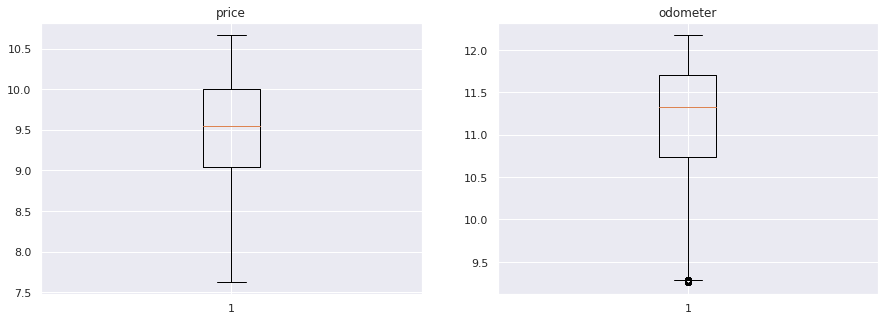

In [ ]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(np.log(cars["price"]), whis=1.5)
plt.title("price")

plt.subplot(1,2,2)
plt.boxplot(np.log(cars["odometer"]), whis=1.5)
plt.title("odometer")
plt.show()

####Much cleaner looking continuous variables.

In [ ]:
# Confirm stability of continuous numeric values after removing outliers:

cars.describe()

,price,year,odometer
count,33864.000,33864.000,33864.000
mean,16113.995,2010.753,86250.181
std,9742.311,8.849,46745.516
min,2050.000,1900.000,10547.000
25%,8495.000,2008.000,46000.000
50%,13990.000,2013.000,82764.000
75%,21999.000,2016.000,121000.000
max,42988.000,2020.000,194144.000


##Categorical variables:

In [ ]:
#Investigate nulls

Nan_sum = cars.isnull().sum()
Nan_sum

region              0
price               0
year                0
manufacturer      898
model             261
condition       10342
cylinders       12717
fuel              115
odometer            0
title_status      106
transmission      168
drive           10743
size            24686
type             6558
paint_color      9739
state               0
dtype: int64

In [ ]:
# What percent are null 
cars.isnull().mean()

region         0.000
price          0.000
year           0.000
manufacturer   0.027
model          0.008
condition      0.305
cylinders      0.376
fuel           0.003
odometer       0.000
title_status   0.003
transmission   0.005
drive          0.317
size           0.729
type           0.194
paint_color    0.288
state          0.000
dtype: float64

###Eliminate any category having more than 40% null values:

In [ ]:
cars.drop(cars.columns[cars.apply(lambda col: col.isnull().mean() > 0.4)], axis=1, inplace=True)

In [ ]:
# Variable size has been eliminated because 73% is missing from listings.
cars.columns

Index(['region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'type', 'paint_color', 'state'],
      dtype='object')

###Categorical investigation.
1. Replace nan with appropriate alternative
2. Investigate and consider encoding options for categorical features.

In [ ]:
cars.manufacturer.unique()

array(['chevrolet', 'nissan', 'ford', 'lexus', 'hyundai', 'honda',
       'dodge', 'toyota', 'subaru', 'mercedes-benz', 'jeep', 'cadillac',
       'gmc', 'ram', 'kia', 'bmw', 'mazda', nan, 'pontiac', 'jaguar',
       'saturn', 'volkswagen', 'audi', 'infiniti', 'chrysler', 'lincoln',
       'acura', 'buick', 'fiat', 'mini', 'rover', 'mitsubishi', 'volvo',
       'mercury', 'porsche', 'tesla', 'alfa-romeo', 'datsun',
       'aston-martin', 'harley-davidson', 'land rover'], dtype=object)

In [ ]:
# delete 'harley-davidson' as we are looking at cars not motorcycles.
cars.drop(cars[cars['manufacturer']=='harley-davidson'].index, inplace=True)

In [ ]:
print("condition: ", cars.condition.unique())
print("\nmodel: ", cars.model.unique())
print("\nfuel: ", cars.fuel.unique())
print("\nCylinders: ",cars.cylinders.unique())
print("\ntitle_status: ", cars.title_status.unique())
print("\ntransmission: ", cars.transmission.unique())
print("\ndrive: ", cars.drive.unique())
print("\npaint_color: ", cars.paint_color.unique())
print("\ntype: ", cars.type.unique())

condition:  ['excellent' 'good' nan 'like new' 'fair' 'salvage' 'new']

model:  ['corvette' 'maxima' 'f-150' ... 'x5 awd 4dr 35d' 'm45'
 'transit connect cargo van']

fuel:  ['gas' 'other' 'diesel' 'hybrid' 'electric' nan]

Cylinders:  ['8 cylinders' '6 cylinders' nan '4 cylinders' '5 cylinders'
 '10 cylinders' 'other' '3 cylinders' '12 cylinders']

title_status:  ['clean' 'salvage' 'missing' 'lien' nan 'rebuilt' 'parts only']

transmission:  ['manual' 'automatic' 'other' nan]

drive:  ['rwd' 'fwd' '4wd' nan]

paint_color:  ['black' 'silver' 'red' 'blue' nan 'white' 'brown' 'grey' 'yellow' 'green'
 'orange' 'custom' 'purple']

type:  ['coupe' 'sedan' 'pickup' 'hatchback' nan 'SUV' 'truck' 'convertible'
 'wagon' 'other' 'mini-van' 'van' 'offroad' 'bus']


In [ ]:
# replace Nan with 'other' or category mode for 'title', 'transmission', and 'title_status'.
categories = ['transmission', 'fuel', 'title_status', 'manufacturer', 
              'model', 'condition', 'cylinders', 'drive', 'type', 'paint_color']

for col in categories:
  cars[col].fillna('other', inplace=True)

cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33857 entries, 0 to 41847
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   region        33857 non-null  object
 1   price         33857 non-null  int64 
 2   year          33857 non-null  int64 
 3   manufacturer  33857 non-null  object
 4   model         33857 non-null  object
 5   condition     33857 non-null  object
 6   cylinders     33857 non-null  object
 7   fuel          33857 non-null  object
 8   odometer      33857 non-null  int64 
 9   title_status  33857 non-null  object
 10  transmission  33857 non-null  object
 11  drive         33857 non-null  object
 12  type          33857 non-null  object
 13  paint_color   33857 non-null  object
 14  state         33857 non-null  object
dtypes: int64(3), object(12)
memory usage: 4.1+ MB


In [ ]:
cars.tail()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
41843,SF bay area,2999,2000,honda,odyssey,excellent,6 cylinders,gas,188301,clean,automatic,fwd,mini-van,other,ca
41844,SF bay area,29987,2018,bmw,x2,other,4 cylinders,gas,18409,clean,automatic,4wd,SUV,black,ca
41845,SF bay area,5900,2000,toyota,tacoma,other,other,gas,139000,clean,manual,rwd,other,other,ca
41846,SF bay area,16500,2016,honda,cr-v,other,other,gas,57818,clean,automatic,fwd,other,other,ca
41847,SF bay area,16000,2019,dodge,grand caravan gt,good,other,other,37882,clean,automatic,fwd,van,other,ca


## All variables have been cleaned up through Exploratory Data Analysis(EDA).  We will gather a bit more perspective through visualizations before we develop our Supervised Learning Model.

#Variable visualization:

###I. Categorical features:

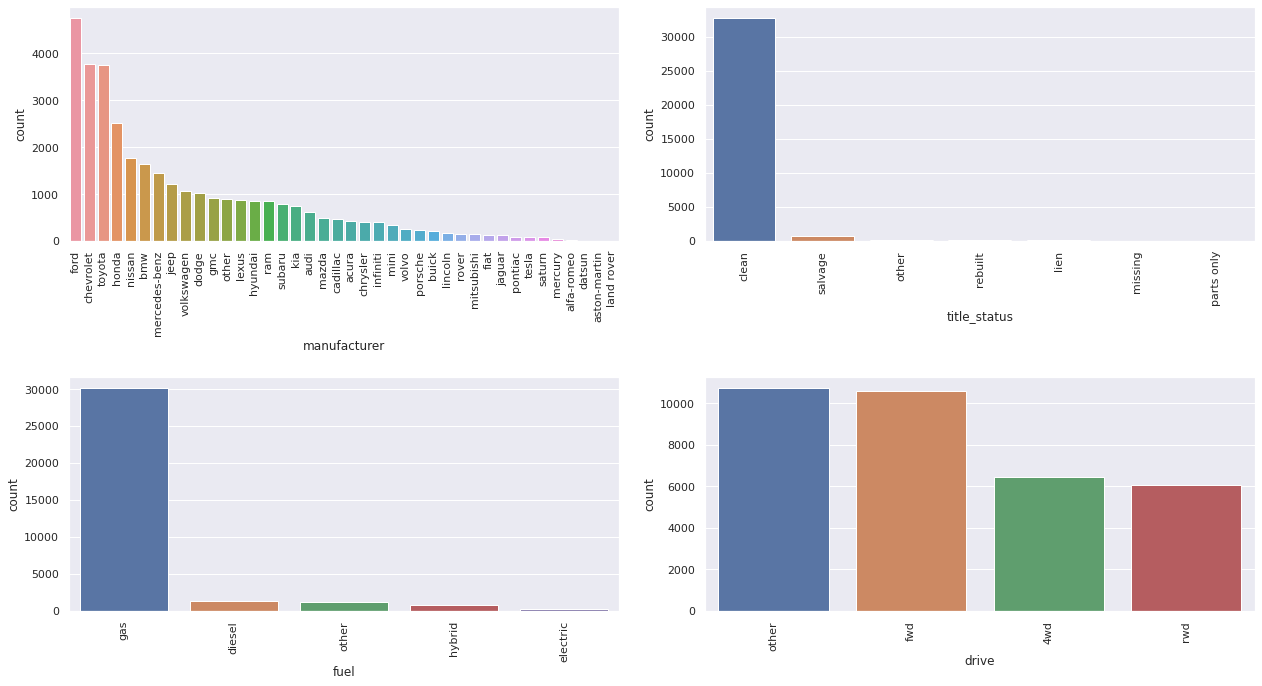

In [ ]:
col_t = ['manufacturer', 'title_status', 'fuel', 'drive']
#, 'fuel','title_status', 'transmission', 'drive', 'size', 'type', 'paint_color'

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,10))

for i, var in enumerate(col_t):
  row = i//2
  col = i % 2
  plot = sns.countplot(x=var, data=cars, order = cars[var].value_counts().index, ax=axs[row][col])
  var = plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
fig.tight_layout(pad=2.0)

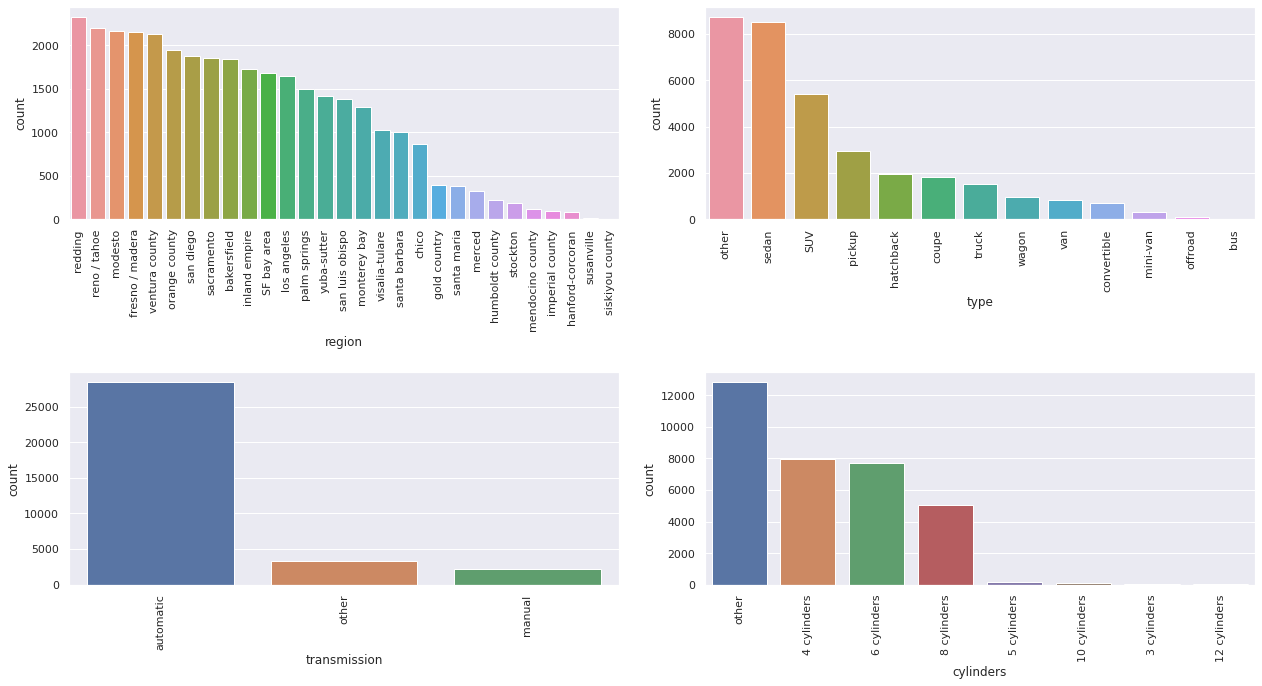

In [ ]:
col_t2 = ['region', 'type', 'transmission','cylinders']
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 10)) 

for i, var in enumerate(col_t2):
    row = i//2
    col = i % 2    
    plot = sns.countplot(x=var, data=cars, order = cars[var].value_counts().index, ax=axs[row][col])
    var = plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
fig.tight_layout(pad=2.0)

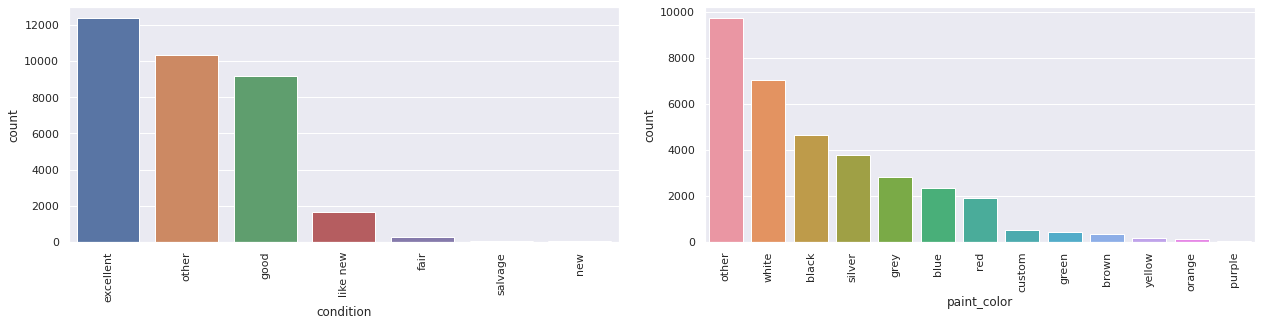

In [ ]:
col = ['condition', 'paint_color']

fig, axs = plt.subplots(ncols=2, figsize=(18,5))

for i, var in enumerate(col):
  row = i//2
  col = i % 2
  plot = sns.countplot(x=var, data=cars, order = cars[var].value_counts().index, ax=axs[col])
  var = plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
fig.tight_layout(pad=2.0)

##II. Continuous Feature 'year' revisited:

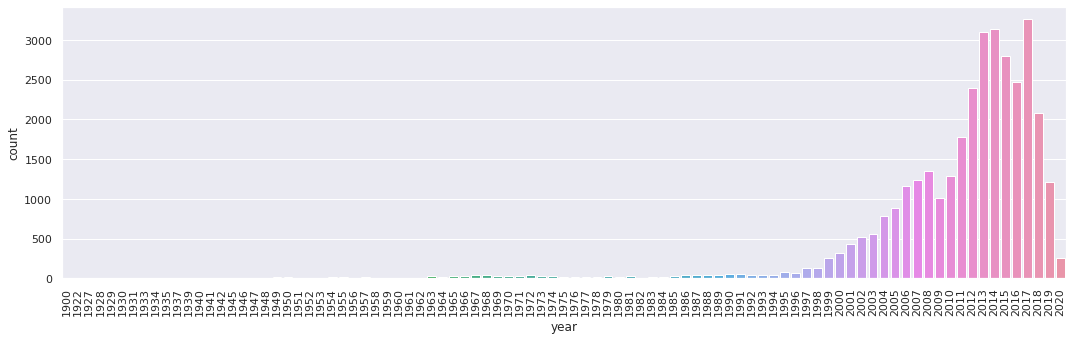

In [ ]:
# YEAR
plt.figure(figsize=(18,5))
sns.set_theme(style="darkgrid")
stat = sns.countplot(x="year", data=cars)
var = stat.set_xticklabels(stat.get_xticklabels(), rotation=90)

###It appears we are looking at too many model years.  At some point cars at a certain age become collectors, antiques, or just too difficult to quantify.  So we will filter our cars from the year 2000 to present 2021.  We will continue to tweak and clean data as we see fit.


In [ ]:
cars = cars[cars.year >= 2000]

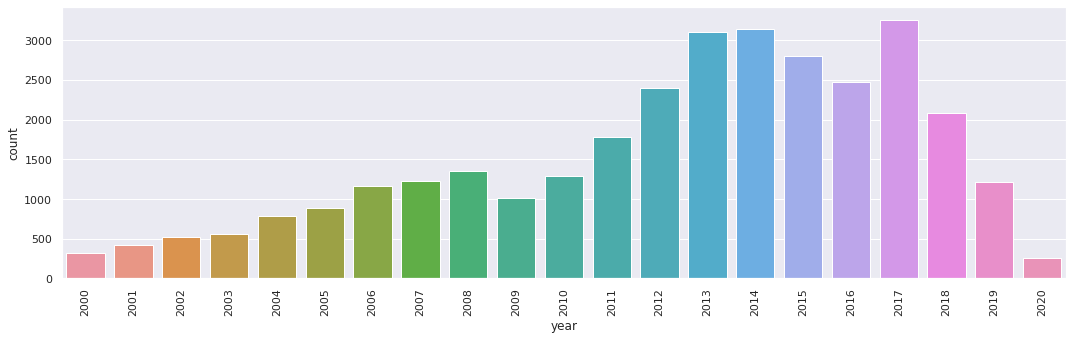

In [ ]:
# YEAR
plt.figure(figsize=(18,5))
sns.set_theme(style="darkgrid")
stat = sns.countplot(x="year", data=cars)
var = stat.set_xticklabels(stat.get_xticklabels(), rotation=90)

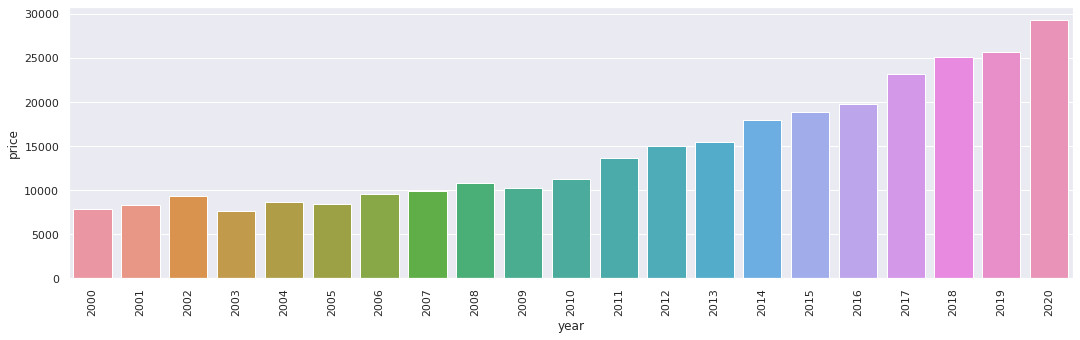

In [ ]:
# Mean price per year

price_ave = cars[['price','year']].groupby('year').mean()

plt.figure(figsize=(18,5))
pr = sns.barplot(x=price_ave.index, y="price", data=price_ave)
var = pr.set_xticklabels(pr.get_xticklabels(), rotation=90)

In [ ]:
cars.groupby(['manufacturer','model','year'])['price'].transform(lambda x: x.mean())

0        24788.347826
2        11054.388889
3        22752.704545
4        14499.000000
5        22504.285714
             ...     
41843     3284.714286
41844    27943.500000
41845    10599.750000
41846    17411.500000
41847    17995.000000
Name: price, Length: 32064, dtype: float64

In [ ]:
cars.shape

(32064, 15)

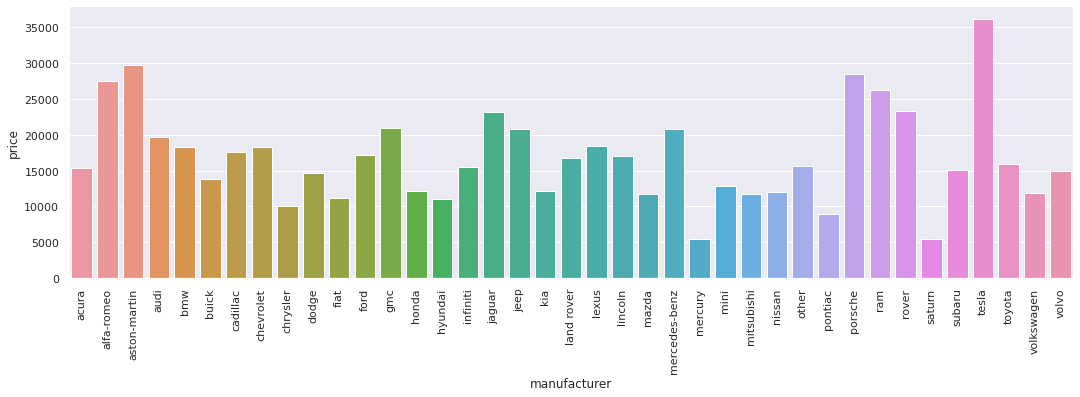

In [ ]:
# Average Price per Manufacturer

ave_price_make = cars[['price','manufacturer']].groupby('manufacturer').mean()

plt.figure(figsize=(18,5))
pr = sns.barplot(x=ave_price_make.index, y="price", data=ave_price_make)
var = pr.set_xticklabels(pr.get_xticklabels(), rotation=90)
var = stat.set_xticklabels(stat.get_xticklabels(), rotation=90)

#Categorical Feature Engineering:
1. Encode according to significance initially

##Encoding:
###1. Fuel, transmission, and title to binary: gas/!gas, automatic/!automatic, clean/!clean
###2. Manufacturer needs to be given a numerical value.  So we will convert to a continuous value representing the average price of that manufacturer.
###3. Model will likewise be converted to a numerical value representing the average price per manufacturer, per model, per corresponding year.  
###4. The remaining categorical features will be encoded with dummies.

In [ ]:
# cars2 will become the transformed dataframe we will use for training and evaulating models.
cars2 = cars.copy()

# 1. Binary
equiv_values2 = {
                "transmission": {"automatic": 1, "manual":0, "other":0},
                "title_status": {"clean": 1, "salvage":0, "missing":0, "lien":0, "other":0, "rebuilt":0, "parts only":0 },
                "fuel":         {"gas": 1, "hybrid":0, "diesel":0, "electric":0, "other":0},
}

cars2 = cars2.replace(equiv_values2)

cars2

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
0,yuba-sutter,25999,2007,chevrolet,corvette,excellent,8 cylinders,1,53846,1,0,rwd,coupe,black,ca
2,yuba-sutter,10999,2012,nissan,maxima,excellent,6 cylinders,1,98898,1,1,fwd,sedan,silver,ca
3,yuba-sutter,38500,2012,ford,f-150,excellent,8 cylinders,1,107020,1,1,4wd,pickup,black,ca
4,yuba-sutter,15999,2009,lexus,is 250,excellent,6 cylinders,1,45704,1,1,rwd,sedan,red,ca
5,yuba-sutter,22990,2015,chevrolet,silverado 1500 regular,good,6 cylinders,0,12411,1,1,other,pickup,red,ca
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41843,SF bay area,2999,2000,honda,odyssey,excellent,6 cylinders,1,188301,1,1,fwd,mini-van,other,ca
41844,SF bay area,29987,2018,bmw,x2,other,4 cylinders,1,18409,1,1,4wd,SUV,black,ca
41845,SF bay area,5900,2000,toyota,tacoma,other,other,1,139000,1,0,rwd,other,other,ca
41846,SF bay area,16500,2016,honda,cr-v,other,other,1,57818,1,1,fwd,other,other,ca


## Investigate manufacturer and model averages:

In [ ]:
cars2[['manufacturer', 'price']].groupby('manufacturer').mean().head()

,price
manufacturer,
acura,15379.068796
alfa-romeo,27486.000000
aston-martin,29749.500000
audi,19681.377207
bmw,18262.485431


In [ ]:
cars.groupby(['manufacturer','model','year'])['price'].transform(lambda x: x.mean())

0        24788.347826
2        11054.388889
3        22752.704545
4        14499.000000
5        22504.285714
             ...     
41843     3284.714286
41844    27943.500000
41845    10599.750000
41846    17411.500000
41847    17995.000000
Name: price, Length: 32064, dtype: float64

In [ ]:
# 2. Encoding avg_price_make
cars2 = cars.copy()
# Reset index for work around below:
cars2.reset_index(drop=True, inplace=True)
cars2['ave_price_make'] = cars.groupby(['manufacturer','year'])['price'].transform(lambda x: x.mean())

cars2.head(3)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,ave_price_make
0,yuba-sutter,25999,2007,chevrolet,corvette,excellent,8 cylinders,gas,53846,clean,manual,rwd,coupe,black,ca,15100.470968
1,yuba-sutter,10999,2012,nissan,maxima,excellent,6 cylinders,gas,98898,clean,automatic,fwd,sedan,silver,ca,NaN
2,yuba-sutter,38500,2012,ford,f-150,excellent,8 cylinders,gas,107020,clean,automatic,4wd,pickup,black,ca,10122.354545


In [ ]:
cars2.reset_index(drop=True, inplace=True)

##Adding an average price per model (ave_price_model) to quantify significance of a particular vehicles attributes relative to it's year and asking price.

In [ ]:
#3. Encoding ave_price_model

# Some initial investigation into accessing desired data:
cars2[['manufacturer', 'price']].groupby('manufacturer').mean()
apm = pd.DataFrame(cars2.groupby(['manufacturer', 'model', 'year']).price.mean())
apm

price
manufacturer model                    year         
acura        3.2 tl                   2004   5999.0
                                      2010  10995.0
             ilk                      2015  14000.0
             ilx                      2013  13999.0
                                      2014  14845.0
...                                             ...
volvo        xc90 awd t6              2004   6800.0
             xc90 t6 awd              2004   4800.0
                                      2017  36900.0
             xc90 t6 awd momentum     2018  37977.0
             xc90 t6 miles 20,000 low 2018  37977.0

[10982 rows x 1 columns]

In [ ]:
# Code to add 'ave_price_model' category to cars2:
  
cars2['ave_price_model']=cars2.groupby(['manufacturer','model','year'])['price'].transform(lambda x: x.mean())

In [ ]:
cars2.head(3)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,ave_price_make,ave_price_model
0,yuba-sutter,25999,2007,chevrolet,corvette,excellent,8 cylinders,gas,53846,clean,manual,rwd,coupe,black,ca,15100.470968,24788.347826
1,yuba-sutter,10999,2012,nissan,maxima,excellent,6 cylinders,gas,98898,clean,automatic,fwd,sedan,silver,ca,NaN,11054.388889
2,yuba-sutter,38500,2012,ford,f-150,excellent,8 cylinders,gas,107020,clean,automatic,4wd,pickup,black,ca,10122.354545,22752.704545


In [ ]:
#4. Encoding dummies

df_encoded = cars2.copy()

# Encode character string categorical data into numeric data using one-hot encoding
df_encoded = pd.concat([cars2, pd.get_dummies(cars2["condition"], drop_first=True)], axis=1)
df_encoded = pd.concat([df_encoded, pd.get_dummies(cars2["cylinders"], drop_first=True)], axis=1)
df_encoded = pd.concat([df_encoded, pd.get_dummies(cars2["drive"], drop_first=True)], axis=1)
df_encoded = pd.concat([df_encoded, pd.get_dummies(cars2["type"], drop_first=True)], axis=1)
df_encoded = pd.concat([df_encoded, pd.get_dummies(cars2["paint_color"], drop_first=True)], axis=1)
df_encoded = pd.concat([df_encoded, pd.get_dummies(cars2["title_status"], drop_first=True)], axis=1)
df_encoded = pd.concat([df_encoded, pd.get_dummies(cars2["fuel"], drop_first=True)], axis=1)
df_encoded = pd.concat([df_encoded, pd.get_dummies(cars2["transmission"], drop_first=True)], axis=1)

df_encoded.drop(['region','state', 'manufacturer','model', 'condition', 'cylinders','drive', 'type', 'paint_color'], axis = 1, inplace = True)
df_encoded

,price,year,fuel,odometer,title_status,transmission,ave_price_make,ave_price_model,fair,good,like new,new,other,salvage,12 cylinders,3 cylinders,4 cylinders,5 cylinders,6 cylinders,8 cylinders,other,fwd,other,rwd,bus,convertible,coupe,hatchback,mini-van,offroad,other,pickup,sedan,truck,van,wagon,blue,brown,custom,green,grey,orange,other,purple,red,silver,white,yellow,1,1,1
0,25999,2007,1,53846,1,0,18260.884,24788.348,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,10999,2012,1,98898,1,1,11983.339,11054.389,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1
2,38500,2012,1,107020,1,1,17108.486,22752.705,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
3,15999,2009,1,45704,1,1,18391.351,14499.000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1
4,22990,2015,0,12411,1,1,18260.884,22504.286,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32059,2999,2000,1,188301,1,1,12099.964,3284.714,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1
32060,29987,2018,1,18409,1,1,18262.485,27943.500,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
32061,5900,2000,1,139000,1,0,15911.560,10599.750,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
32062,16500,2016,1,57818,1,1,12099.964,17411.500,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1


# Feature Engineering is completed.  Time to test and evaluate differing models.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

pd.options.display.float_format = '{:.3f}'.format

# Establish the Target
Y = cars2['price']
 
# Set the Features
X = df_encoded.drop(columns = ['price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 25651
The number of observations in test set is 6413


##Linearity Visual:

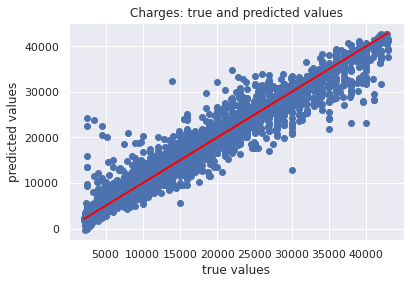

In [ ]:
#OLS for graphing true and predicted values:

X_train = sm.add_constant(X_train)
results = sm.OLS(y_train, X_train).fit()
X_test = sm.add_constant(X_test)
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

###Helper methods for Metrics and Cross-Validation:

In [ ]:
def eval_metrics(y_test, y_preds_test):
  print("\nMAE: Mean absolute error of the prediction is:\t\t\t{}".format(mean_absolute_error(y_test, y_preds_test)))
  print("MSE: Mean squared error of the prediction is:\t\t\t{}".format(mse(y_test, y_preds_test)))
  print("RMSE: Root mean squared error of the prediction is:\t\t{}".format(rmse(y_test, y_preds_test)))
  print("MAPE: Mean absolute percentage error of the prediction is:\t{}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

In [ ]:
def test_results(model):
  print("Cross-validation - 5 fold : ", cross_val_score(model, X, Y, cv=5))
  print("\nR-squared of the model in training set is:\t\t{}".format(model.score(X_train, y_train)))
  print()
  print("-----Test set statistics-----")
  print("R-squared of the model in test set is:\t\t\t{}".format(model.score(X_test, y_test)))

##OLS - Linear Regression Model

In [ ]:
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import cross_val_score

lrm = LinearRegression()
lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

test_results(lrm)
eval_metrics(y_test, y_preds_test)

Cross-validation - 5 fold :  [0.96194888 0.94989928 0.9624966  0.94985251 0.95974664]

R-squared of the model in training set is:		0.9578792939954929

-----Test set statistics-----
R-squared of the model in test set is:			0.9554704911571488

MAE: Mean absolute error of the prediction is:			1215.4788506836924
MSE: Mean squared error of the prediction is:			4189878.1891251686
RMSE: Root mean squared error of the prediction is:		2046.9191945763685
MAPE: Mean absolute percentage error of the prediction is:	10.368984086054873


##Lasso Regression Model

In [ ]:
lasso_cv = LassoCV(cv=5)
lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

test_results(lasso_cv)
eval_metrics(y_test, y_preds_test)

Cross-validation - 5 fold :  [0.96115903 0.94452033 0.9608674  0.9466647  0.95758431]

R-squared of the model in training set is:		0.9550382339567876

-----Test set statistics-----
R-squared of the model in test set is:			0.9522189153121743

MAE: Mean absolute error of the prediction is:			1197.2283113511012
MSE: Mean squared error of the prediction is:			4495826.021633816
RMSE: Root mean squared error of the prediction is:		2120.336299183178
MAPE: Mean absolute percentage error of the prediction is:	9.95167722285804


##Ridge Regression Model

In [ ]:
ridge_cv = RidgeCV(cv=5)
ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

test_results(ridge_cv)
eval_metrics(y_test, y_preds_test)

Cross-validation - 5 fold :  [0.96196035 0.94988287 0.96252534 0.94985211 0.95978792]

R-squared of the model in training set is:		0.9578763670720186

-----Test set statistics-----
R-squared of the model in test set is:			0.9554724148969428

MAE: Mean absolute error of the prediction is:			1214.314264285822
MSE: Mean squared error of the prediction is:			4189697.180270284
RMSE: Root mean squared error of the prediction is:		2046.874979149993
MAPE: Mean absolute percentage error of the prediction is:	10.354493577530624


##ElasticNet Regression Model

In [ ]:
elasticnet_cv = ElasticNetCV(cv=5)
elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

test_results(elasticnet_cv)
eval_metrics(y_test, y_preds_test)

Cross-validation - 5 fold :  [0.9610741  0.94452824 0.96081689 0.94673893 0.95757253]

R-squared of the model in training set is:		0.9550250660281392

-----Test set statistics-----
R-squared of the model in test set is:			0.9521809382394497

MAE: Mean absolute error of the prediction is:			1203.4958572931234
MSE: Mean squared error of the prediction is:			4499399.366879049
RMSE: Root mean squared error of the prediction is:		2121.1787682510517
MAPE: Mean absolute percentage error of the prediction is:	9.996260061125284


In [ ]:
#COnfirm and Summarize Results
lcv = LassoCV().fit(X_train,y_train)
rcv = RidgeCV().fit(X_train,y_train)
encv= ElasticNetCV().fit(X_train,y_train)

print("Method (R-squared):\ttrain\t\t\ttest")
print("LinReg:\t\t\t", lrm.score(X_train,y_train),"\t", lrm.score(X_test,y_test))
print("LassoCV:\t\t", lcv.score(X_train,y_train),"\t", lcv.score(X_test,y_test))
print("RidgeCV:\t\t", rcv.score(X_train,y_train),"\t", rcv.score(X_test,y_test))
print("ElasticNetCV:\t\t",encv.score(X_train,y_train),"\t", encv.score(X_test,y_test))

Method (R-squared):	train			test
LinReg:			 0.9578792939954929 	 0.9554704911571488
LassoCV:		 0.9550382339567876 	 0.9522189153121743
RidgeCV:		 0.9578746589587164 	 0.9554629495068883
ElasticNetCV:		 0.9550250660281392 	 0.9521809382394497


#Model Summary:
##All four models are extremely close in both training and test accuracy.  The OLS Linear Regression and Ridge Regression models have a slight edge in both training and testing accuracy.  One the other hand, The MAE, MSE, RMSE, and MAPE give varying indicators.  The MAE scores for Lasso and ElasticNet are better(lower) than OLS and Ridge scores. None of these four prediction indicators are substantially lower than any of the other ones.

##Conclusion: Any of the four testing models used would result in a favorable prediction accuracy between 95.2% - 95.5%. All 4 tests have 2 of the 5-fold cross-validation scores reaching the 96% threshold.  That is, supplying the corresponding features of a car to be listed on Craigslist.com would result in a listing price at approximately 95% of what people feel is the appropriate listing price.

###NOTE - The key to achieving such a relatively high predictive accuracy score hinged upon quantifying the vehicle's model feature.  Replacing the model with the average price with respect to it's year was significant.

#The following graphs give some interesting insight into the used car market in California.

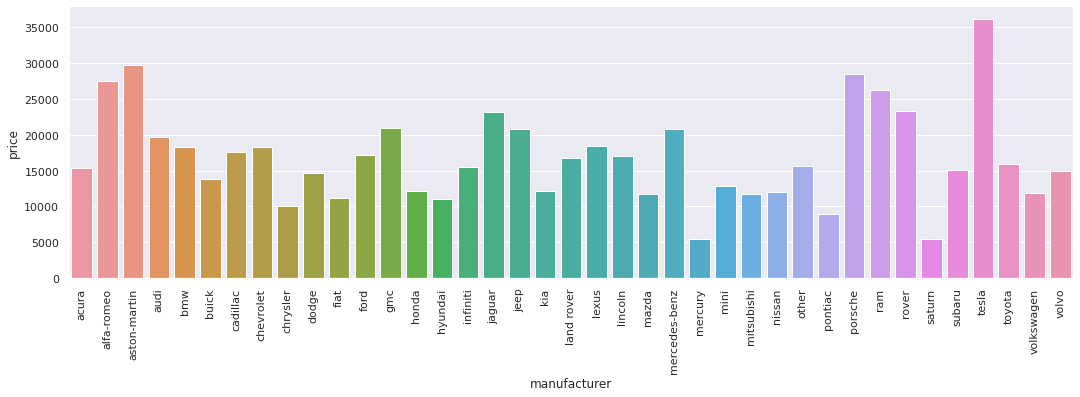

In [ ]:
# Mean price per manufacturer

price_ave = cars[['price','manufacturer']].groupby('manufacturer').mean()

plt.figure(figsize=(18,5))
pr = sns.barplot(x=price_ave.index, y="price", data=price_ave)
var = pr.set_xticklabels(pr.get_xticklabels(), rotation=90)

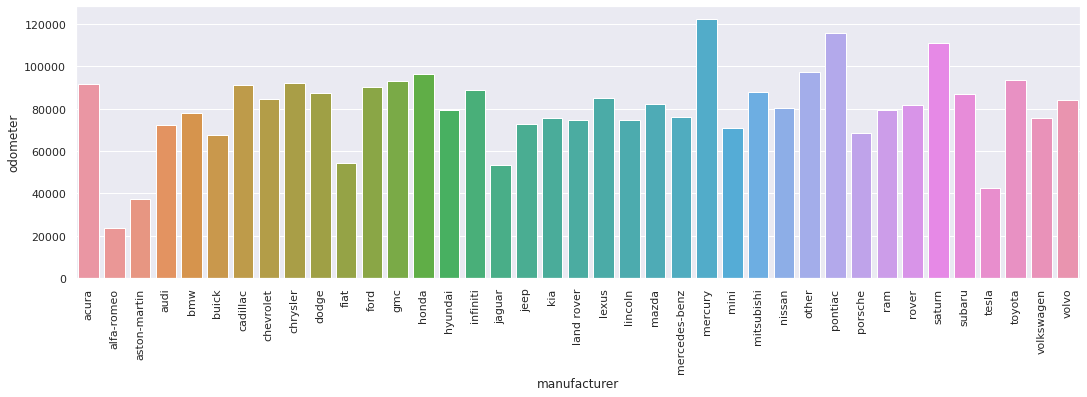

In [ ]:
# Odometer mean per manufacturer

odometer_mean = cars[['odometer','manufacturer']].groupby('manufacturer').mean()

plt.figure(figsize=(18,5))
pr = sns.barplot(x=odometer_mean.index, y="odometer", data=odometer_mean)
var = pr.set_xticklabels(pr.get_xticklabels(), rotation=90)

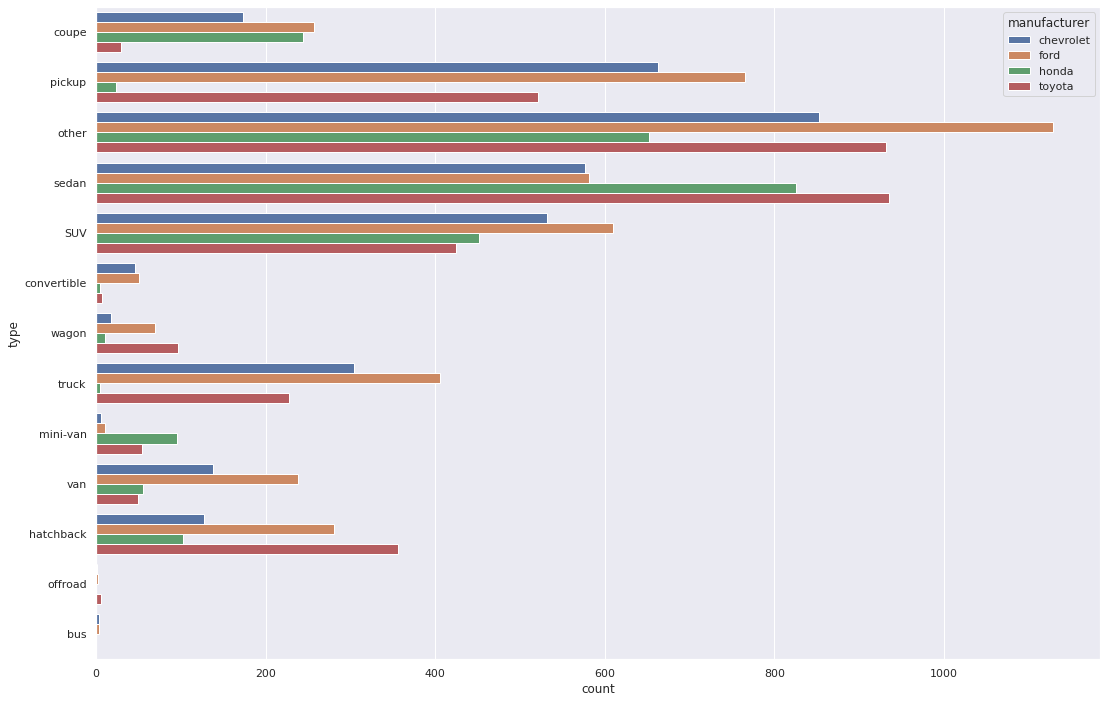

In [ ]:
# Breakdown of the top4 manufacturers:
top4 = ['ford', 'chevrolet', 'toyota', 'honda']

v = cars.loc[(cars['manufacturer'].isin(top4)), :].copy()

plt.subplots(figsize=(18, 12)) 
sns.countplot(y="type", hue="manufacturer", data=v)

#Further Considerations:
##Adjusting this model to incorporate sales price would be optimal.  The ability to predict the best listing price to maximize sales price  would be an ideal direction to pursue.